In [1]:
import numpy as np 
import pandas as pd
import torch 
from bokeh.models import ColumnDataSource

import sys
import os

current_path = notebook_dir = os.getcwd()
working_dir = os.path.abspath(os.path.join(current_path, '..','..'))
if working_dir not in sys.path:
    sys.path.insert(0, working_dir)

from jupyter_ipynb.Entropy_and_information.utils import correlation_coefficient
from jupyter_ipynb.Entropy_and_information.entropy import TimeSeriesInfo
from jupyter_ipynb.Entropy_and_information.lagged_feature import KSGEstimator,KDEEstimator,TimeSeriesTECalculator
from jupyter_ipynb.Entropy_and_information.Multivariate_CCM import build_multivariate_embedding,ccm_reconstruct_multivariate,get_embedding_and_reconstruct
from  jupyter_ipynb.Entropy_and_information.Multivariate_CCM import plot_reconstruction as ccm_plot_reconstruction
from jupyter_ipynb.Entropy_and_information.generate_variables import load_variables_lorenz,plot_lorenz
from jupyter_ipynb.Entropy_and_information.generate_variables import load_variables_subway_bar,plot_subway_bar
from jupyter_ipynb.Entropy_and_information.generate_variables import load_variables_sinusoidales
from jupyter_ipynb.Entropy_and_information.plotting import visualize_TE


## Load Time Series:

In [7]:
t,x,y,z = load_variables_sinusoidales(n=100,T=10*np.pi,lag=np.pi/3,noise=True,seed=42,cos=True)

# Information, Entropy and Transfer Entropy:

**Définition d'Entropie** :
`L'entropie de Shannon (1948)` est par défintion une mesure pour l'incertitude, qui augmente avec le nombre de bits necessaire pour encoder une séquence de réalisations de X. 
- X doit être une VAD (variable aléatoire `discrète`)
$$
H(X) = - \sum_{x} p(x)\,\ln p(x),
$$
- H(X) > 0

Il existes d'autres définitions de l'entropie, comme la `Rényi Entropy` (1970) qui est défini par 
$$ 
H^{q}(X) = \frac{1}{1-q} \log \left( \sum_{x} p^{q}(x) \right)
$$
Mais nous allons utiliser dans la suite l'entropie de Shannon.
## Calcul de l'entropie par discrétisation

Pour estimer l'entropie d'une série temporelle réelle $ (\{x_t\}) $ à partir d'un **histogramme** (binning), on procède comme suit :

1. **Discrétisation** : on découpe l'axe des valeurs en un nombre fini de catégories (bins), par exemple $B$.  
   - Pour chaque point $ (x_t) $, on identifie dans quel bin il tombe (entier $ (0 \le b < B) $.  
2. **Estimation de la loi de probabilité** : on compte la fréquence de chaque bin dans la série.  
   - Par exemple, $ p(b) = \frac{\text{nombre d'éléments dans le bin } b}{N} $, où  $N$ est la taille totale de l'échantillon.  
3. **Calcul de l'entropie (Shannon Entropy)** :  
$$
H(X) = - \sum_{b=0}^{B-1} p(b)\,\ln p(b),
$$
en ignorant les bins vides (où $p(b)=0$).

Cette méthode s'étend aussi aux **entropies conjointes** (avec 2 bins, 3 bins, etc.) en formant un histogramme multi-dimensionnel, et aux **entropies conditionnelles**.

---

### Mutual Information (2 variables)
La **Mutual Information** (information mutuelle) $I(X;Y)$ entre deux variables $X$ et $Y$
` mesure combien la connaissance de X diminue l’incertitude sur Y` (et réciproquement car I symétrique)

Elle s’écrit :

$$
I(X; Y) \;=\; H(X) \;+\; H(Y) \;-\; H(X, Y).
$$

En pratique, on estime la loi conjointe $\hat{p}(x,y)$ par un histogramme 2D, et les lois marginales $\hat{p}(x)$ et $\hat{p}(y)$ par des histogrammes 1D.

---

### Transfer Entropy (2 variables)
La Mutual Information ne permet pas de distinguer si X apporte quelque chose qui n'est pas déjà contenue dans Y. Alors, il faut regarder une information mutuelle conditionnelle, qui traduira plutôt Si X apporte une information supplémentaire à celle déjà contenue dans l’historique de Y. En fait elle mesure `La quantité d'incertitude réduite sur les futures valeurs de Y d'après les 

Pour deux séries temporelles $X$ et $Y$, la **Transfer Entropy** (simplifiée à 1 pas) de $X$ vers $Y$ est :

$$
\mathrm{TE}(X \rightarrow Y) \;=\; \sum_{x_t, x_{t+1}, y_t} p\bigl(x_{t+1}, x_t, y_t\bigr) 
\,\ln \!\biggl[\frac{p\bigl(x_{t+1}\,\bigm|\,x_t, y_t\bigr)}{p\bigl(x_{t+1}\,\bigm|\,x_t\bigr)}\biggr].
$$

On peut l’interpréter comme une **information mutuelle conditionnelle** :
$$
\mathrm{TE}(X\rightarrow Y) \;=\; I\bigl(X_t; Y_{t+1}\;\bigm|\;Y_t\bigr).
$$

---

### Transfer Entropy (3 variables)

Si on veut évaluer l’influence de **\(X\) et \(Z\)** sur \(Y\), on calcule la TE **multivariée** :

$$
\mathrm{TE}(\{X,Z\}\rightarrow Y) \;=\; I\bigl(\{X,Z\}_t;\;Y_{t+1}\;\bigm|\;Y_t\bigr),
$$
ce qui se généralise en formant un **histogramme multi-dimensionnel** \(\hat{p}(x_t, z_t, y_t, y_{t+1})\).

---

### Remarque

Dans tous les cas (entropie, mutual information, transfer entropy), **la logique de “binning” et de comptage** est la même :  
- On associe chaque échantillon à un bin (ou une combinaison de bins pour plusieurs variables).  
- On estime **empiriquement** \(p(\cdot)\) à partir du nombre de points dans chaque bin.  
- On applique les formules \(\sum p \,\ln(\dots)\) pour estimer l'entropie ou l'information mutuelle.


In [8]:
nb_bins = 10
window_size = 6

tsi = TimeSeriesInfo(nb_bins=nb_bins)

## Calcul direct de l'entropie: 

<Axes: >

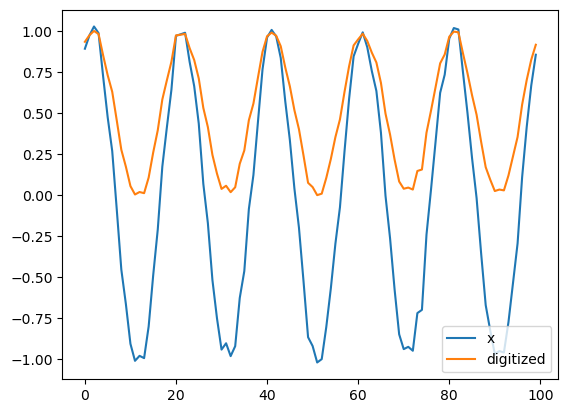

In [45]:
nb_bins = 1000
hist, bin_edges = np.histogram(x, bins=nb_bins)
digitized = np.digitize(x, bin_edges[1:-1])/nb_bins
pd.DataFrame(dict(x=x,digitized=digitized)).plot()

In [18]:
digitized = tsi.digitize_series(x, 100)
digitized

array([93, 97, 99, 98, 85, 73, 62, 45, 27, 17,  5,  0,  1,  1, 10, 26, 39,
       58, 69, 81, 97, 97, 98, 89, 82, 71, 53, 41, 24, 13,  3,  5,  1,  4,
       19, 27, 45, 55, 71, 87, 96, 98, 97, 90, 77, 66, 51, 40, 24,  7,  4,
        0,  0, 10, 22, 35, 46, 62, 78, 91, 94, 98, 93, 86, 80, 68, 49, 36,
       21,  8,  3,  4,  3, 14, 15, 38, 51, 65, 80, 85, 96, 99, 99, 86, 74,
       60, 48, 32, 17,  9,  2,  3,  2, 12, 23, 35, 55, 70, 82, 91])

In [9]:
mi_xy = tsi.sliding_window_mutual_info(x, y, window_size=window_size)  # Exemple 1 : I(X;Y) sur des fenêtres glissantes
te_xy = tsi.sliding_window_transfer_entropy(x, y, window_size=window_size)  # Exemple 2 : Transfer Entropy (X->Y) ~ I(X_t; Y_{t+1} | Y_t)
te_xzy = tsi.sliding_window_multi_transfer_entropy([x, z], y, window_size=window_size) # Exemple 3 : Transfer Entropy multi-séries {X, Z} -> Y

In [14]:
source = ColumnDataSource(data={'Time':t[window_size-1:],'explainable':x[window_size-1:],'target':y[window_size-1:],'MI':mi_xy})
p1 = visualize_TE(source,time = 'Time',explainable = 'explainable', target = 'target',TE = 'MI',title= 'MI(X,Y) (Mutual Information) plotted on X')

source = ColumnDataSource(data={'Time':t[window_size:],'explainable':x[window_size:],'target':y[window_size:],'TE':te_xy})
p2 =visualize_TE(source,time = 'Time',explainable = 'explainable', target = 'target',TE = 'TE',title='TE(X -> Y) plotted on X (explainable variable)')

source = ColumnDataSource(data={'Time':t[window_size:],'explainable1':x[window_size:],'explainable2':z[window_size:],'target':y[window_size:],'TE':te_xzy})
visualize_TE(source,time = 'Time',explainable = ['explainable1','explainable2'], target = 'target',TE = 'TE',title='TE(X,Z -> Y) plotted on Z (explainable variable)')


Loading BokehJS ...

Loading BokehJS ...

Loading BokehJS ...

figure(id='p2351', ...)

In [ ]:

##########################
# 1) Génération de deux exemples
##########################

def generate_example_1(n=100):
    """
    Exemple trivial (périodique) : 
      X = sin, Y = cos (même fréquence, décalage), Z = un bruit random.
    """
    t = np.arange(n)
    X = np.sin(2 * np.pi * t / 20)  # période ~20
    Y = np.cos(2 * np.pi * t / 20)  # même période, phase décalée
    Z = 0.3 * np.random.randn(n)    # bruit (pas ou très peu lié)
    return t, X, Y, Z

def generate_example_2(n=200):
    """
    Exemple 2 (saisonnalité + bruit) :
      X = 0.5 cos(2π t/24) + bruit
      Y = 0.5 cos(2π (t+3)/24) + léger bruit (décalage ~3)
      Z = 0.5 cos(2π (t+10)/24) + bruit (moins corrélé à Y).
    """
    t = np.arange(n)
    X = 0.5 * np.cos(2 * np.pi * t / 24) + 0.1 * np.random.randn(n)
    Y = 0.5 * np.cos(2 * np.pi * (t + 3) / 24) + 0.1 * np.random.randn(n)
    Z = 0.5 * np.cos(2 * np.pi * (t + 10) / 24) + 0.1 * np.random.randn(n)
    return t, X, Y, Z


##########################
# 2) Fonctions de démo Bokeh
##########################



# Estimateur à Noyau 
## Estimation de la Transfer Entropy via la méthode KSGE

La **méthode KSGE** (extension de l’estimateur KSG initialement proposé par Kraskov, Stögbauer et Grassberger) vise à **estimer la Transfer Entropy (TE)** dans le cas de **variables continues** à l’aide d’une approche basée sur les plus proches voisins (k-nearest neighbors).

### Définition de la Transfer Entropy

Pour deux processus aléatoires \(X\) et \(Y\), la Transfer Entropy (simplifiée à un pas) s’écrit souvent comme :

$$
\mathrm{TE}_{X \rightarrow Y} = \sum_{x_t, y_t, x_{t+1}} p(x_{t+1}, x_t, y_t)\; \ln \!\biggl[\frac{p(x_{t+1} \mid x_t, y_t)}{p(x_{t+1} \mid x_t)}\biggr].
$$

Ici,
- \(x_t\) et \(x_{t+1}\) désignent deux instants successifs de la variable \(X\),
- \(y_t\) désigne l’instant courant de la variable \(Y\),
- \(p(\cdot)\) et \(p(\cdot|\cdot)\) désignent les densités conjointes et conditionnelles.

### Principe de l’estimation KSGE

1. **Représentation des échantillons** : On considère chaque triplet \((x_{t+1}, x_t, y_t)\) (ou quadruplet si on inclut un historique plus grand).
2. **Recherche de k-plus proches voisins** : Pour chaque point dans l’espace (ici, l’espace formé par \((x_t,y_t)\) ou \((x_{t+1}, x_t, y_t)\) suivant le terme à estimer), on recherche ses k-plus proches voisins. 
3. **Estimations des densités** : Les distances calculées servent à approximer les densités jointes et conditionnelles.
4. **Calcul de la TE** : À partir de ces estimations, on obtient une approximation de l’information mutuelle conditionnelle \(\mathrm{I}(X_{t+1};Y_t\mid X_t)\), qui correspond à la Transfer Entropy.

Le principal avantage de la méthode KSGE est qu’elle **ne requiert pas** de **discrétisation** explicite des variables et qu’elle s’adapte bien à des données continues, potentiellement multidimensionnelles.

Pour plus de détails, on peut se référer aux travaux originels de **Kraskov, Stögbauer et Grassberger (2004)** sur l’estimation de l’information mutuelle par méthode à k-plus proches voisins, ainsi qu’à leurs extensions dédiées à la Transfer Entropy.


In [4]:
data_dict = {
    'x': x,
    'y': y,
    'z': z
}

# 2) Choix des lags : ex. X(t), X(t-1), Z(t), Y(t) en condition => on veut TE(X,Z -> Y(t+1) | Y(t))
#    => On inclut y(t) dans la condition => lags_dict['y'] = [0]
#    => On inclut x(t) et x(t-1) => lags_dict['x'] = [0,1]
#    => On inclut z(t) => lags_dict['z'] = [0]
lags_dict = {
    'x': [0, 1],
    'z': [0],
    'y': [0]  # Y(t) en condition
}

# 3) Instancier un estimateur KSG => version non-simplifiée
ksg_est = KSGEstimator(k=5, simplified=False)

# 4) Créer le calculateur TE
te_calc = TimeSeriesTECalculator(estimator=ksg_est)

# 5) Calculer TE dans des fenêtres glissantes
#    TE({X(t),X(t-1),Z(t)} -> Y(t+1) | Y(t))
#    window_size=10
te_values_ksg = te_calc.sliding_window_te(
    data_dict=data_dict,
    lags_dict=lags_dict,
    target_var='y',
    target_offset=1,    # Y(t+1)
    window_size=10
)
print("KSG1 TE({X,Z}->Y):", te_values_ksg)

# 6) Idem version simplifiée KSG
ksg_est_simpl = KSGEstimator(k=5, simplified=True)
te_calc_simpl = TimeSeriesTECalculator(estimator=ksg_est_simpl)
te_values_simpl = te_calc_simpl.sliding_window_te(
    data_dict=data_dict,
    lags_dict=lags_dict,
    target_var='y',
    target_offset=1,
    window_size=10
)
print("KSG simplifié TE({X,Z}->Y):", te_values_simpl)

# 7) KDE
kde_est = KDEEstimator(bandwidth=0.3)
te_calc_kde = TimeSeriesTECalculator(estimator=kde_est)
te_values_kde = te_calc_kde.sliding_window_te(
    data_dict=data_dict,
    lags_dict=lags_dict,
    target_var='y',
    target_offset=1,
    window_size=10
)
print("KDE TE({X,Z}->Y):", te_values_kde)

KSG1 TE({X,Z}->Y): [-0.4940915761200504, -0.6186732984758714, -0.27144872866025116, -0.2741176450956444, -0.37592975182260124, -0.45435919491586185, -0.277963657950552, -0.557887808090221, -0.6552760857105757, -0.4218223131001504, -0.564660958905578, -0.6165406658476011, -0.6488518995815058, -0.5515018299956838, -0.424696910232514, -0.5753341405147507, -0.5485338437294496, -0.4153680040776824, -0.6886693365429735, -0.6327128849109209, -0.7213444653685763, -0.49210279208899843, -0.5248217901142953, -0.45413604969884513, -0.6684524514810706, -0.8309376448847872, -0.8272429362899694, -0.9047564440682758, -0.9053903921106845, -0.663879508922697, -0.631805009636967, -0.6094198931755757, -0.5445509389967407, -0.3291448228511038, -0.4779762095123312, -0.5490709180507476, -0.5225607810101323, -0.4593559020423925, -0.6294497861146024, -0.5177325606352223, -0.5467002914829426, -0.5435564056056661, -0.6157119296393314, -0.5430026002280874, -0.4061602615658946, -0.4807539397906839, -0.601769573953

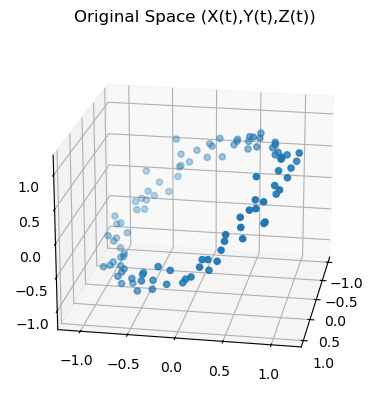

[X-only attracteur] Corrélation CCM(X->Y) = 1.000


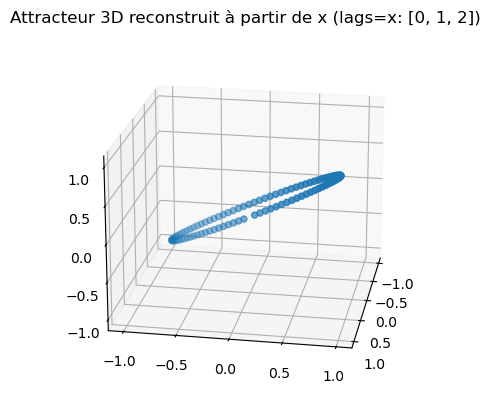

[X-only attracteur] Corrélation CCM(X->Y) = 1.000


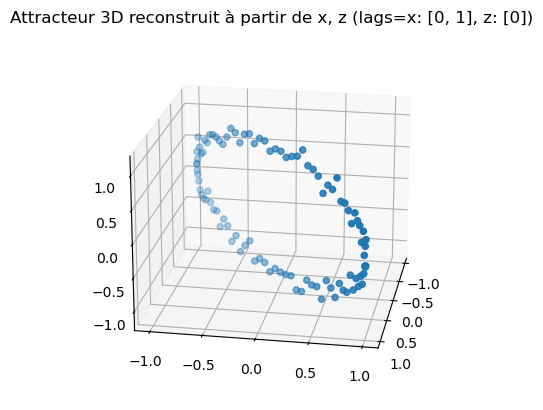

In [5]:
ccm_plot_reconstruction(np.array([x,y,z]).transpose())

data_dict = {'x': x, 'y': y, 'z': z}

lags = {'x': [0, 1, 2]}
y_est,embedding = get_embedding_and_reconstruct(data_dict,target_variable='y',lags=lags,k=4,use_weighted_mean=True)
ccm_plot_reconstruction(embedding,lags)


lags = {'x': [0, 1], 'z': [0]}
y_est,embedding = get_embedding_and_reconstruct(data_dict,target_variable='y',lags=lags,k=4,use_weighted_mean=True)
ccm_plot_reconstruction(embedding,lags)

## Time Serie avec des événements spécifiques présent à des moments particuliers:

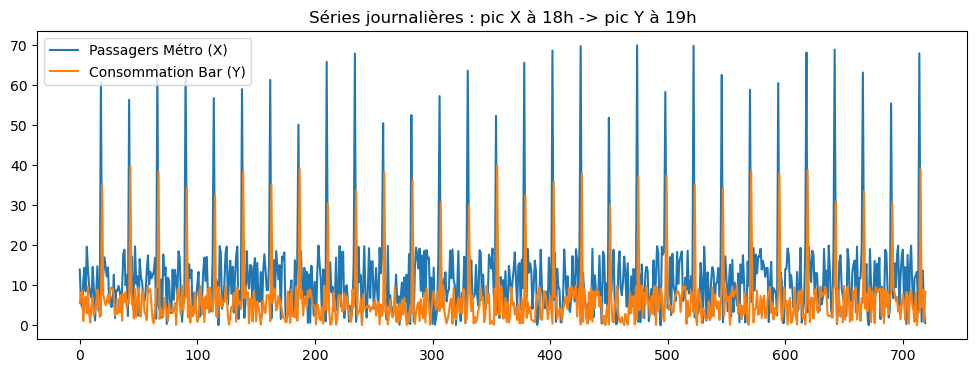

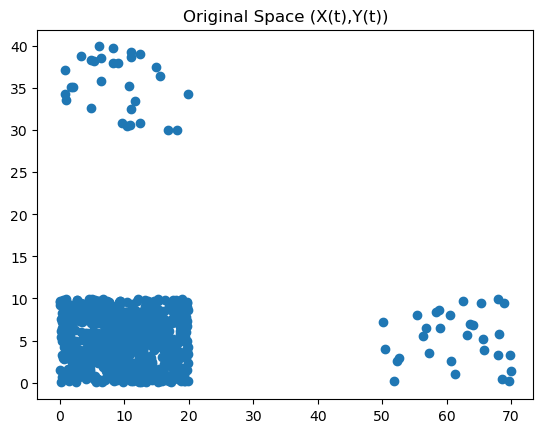

[X-only attracteur] Corrélation CCM(X->Y) = 1.000


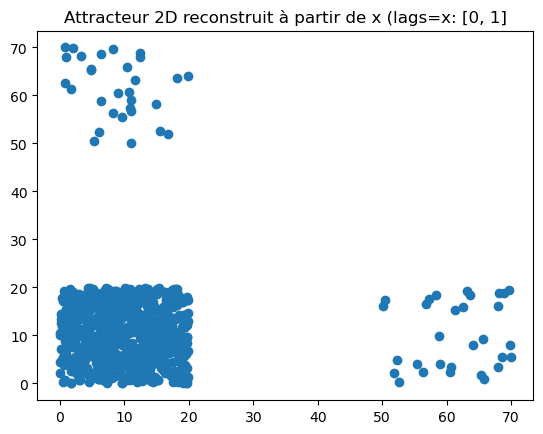

In [6]:
X_metro,Y_alcool = load_variables_subway_bar()
plot_subway_bar(X_metro,Y_alcool)

ccm_plot_reconstruction(np.array([X_metro,Y_alcool]).transpose())

data_dict = {'x': X_metro, 'y': Y_alcool}

lags = {'x': [0, 1]}
y_est,embedding = get_embedding_and_reconstruct(data_dict,target_variable='y',lags=lags,k=4,use_weighted_mean=True)
ccm_plot_reconstruction(embedding,lags)

## Moments identifié, on focus entre 16 et 20h: 

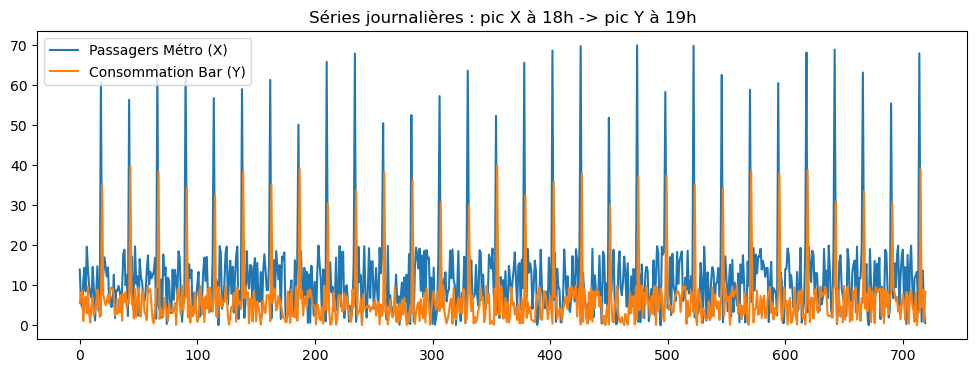

Corrélation CCM(X->Y) (sans décalage explicite) = 1.000
Corrélation CCM(X décalé 1h -> Y) = 1.000
La corrélation n'augmente pas beaucoup : le lien partiel est peut-être masqué par le bruit global.
CCM(X->Y) juste sur la tranche 16h..20h: corrélation = 1.000


In [ ]:
###############################
# Test CCM sur la série brute
###############################
from sklearn.neighbors import NearestNeighbors

def ccm_basic(cause: np.ndarray, effect: np.ndarray, E=2, tau=1, k=4):
    """
    CCM simplifié, on ne reconstruit qu'avec la série cause,
    dimension E, retard tau, k voisins.
    """
    n = len(cause)
    start_idx = (E-1)*tau
    M_points = []
    valid_t = []
    for t in range(start_idx, n):
        coords = [cause[t - i*tau] for i in range(E)]
        M_points.append(coords)
        valid_t.append(t)
    M_points = np.array(M_points)
    valid_t = np.array(valid_t)

    nbrs = NearestNeighbors(n_neighbors=k).fit(M_points)
    y_true = []
    y_est = []
    for i, v in enumerate(M_points):
        dist, idxs = nbrs.kneighbors(v.reshape(1,-1))
        d = dist[0]
        d = np.where(d<1e-12, 1e-12, d)
        w = 1./d
        w /= w.sum()
        neighbors_t = valid_t[idxs[0]]
        val_neigh = effect[neighbors_t]
        val_hat = np.sum(val_neigh * w)
        y_true.append(effect[valid_t[i]])
        y_est.append(val_hat)
    return np.array(y_true), np.array(y_est)



def correlation(x, y):
    return np.corrcoef(x, y)[0,1]

# 1) Sans décalage
Ytrue, Yest = ccm_basic(X_metro, Y_alcool, E=2, tau=1, k=5)
rho_xy = correlation(Ytrue, Yest)
print(f"Corrélation CCM(X->Y) (sans décalage explicite) = {rho_xy:.3f}")

# 2) Décalage d'une heure dans X ?
#    On peut manuellement décaler X de 1h : X_shifted[t] = X[t-1].
#    Ensuite faire CCM(X_shifted->Y) => pour voir si c'est plus corrélé
X_shifted = np.roll(X_metro, 1)  # Décalage circulaire => on pourrait mettre un 0 sur la 1ère case si besoin
Ytrue_shift, Yest_shift = ccm_basic(X_shifted, Y_alcool, E=2, tau=1, k=5)
rho_xshift_y = correlation(Ytrue_shift, Yest_shift)
print(f"Corrélation CCM(X décalé 1h -> Y) = {rho_xshift_y:.3f}")

# Interprétation
if rho_xshift_y > rho_xy + 0.05:  # Seuil arbitraire
    print("On observe qu'avec le décalage de 1h, la corrélation est plus forte, suggérant un lien à 1h de retard.")
else:
    print("La corrélation n'augmente pas beaucoup : le lien partiel est peut-être masqué par le bruit global.")


###############################
# Astuce : segmenter la journée
###############################
# Si vous suspectez que la causalité n'existe qu'autour de 18h->19h, vous pouvez
# extraire la fenêtre [16h..20h] chaque jour et concaténer, etc.
# Ou faire CCM sur cette sous-série. 
#
# Exemple rapide : on regarde seulement la plage 16h..20h sur tous les jours.
window_data_x = []
window_data_y = []
for d in range(days):
    start = d * hours_per_day
    sub_x = X_metro[start+16 : start+21]  # 16h..20h (5 points)
    sub_y = Y_alcool[start+16 : start+21]
    window_data_x.append(sub_x)
    window_data_y.append(sub_y)
window_data_x = np.concatenate(window_data_x)  # shape (days*5,)
window_data_y = np.concatenate(window_data_y)

Ytrue_w, Yest_w = ccm_basic(window_data_x, window_data_y, E=2, tau=1, k=4)
rho_window = correlation(Ytrue_w, Yest_w)
print(f"CCM(X->Y) juste sur la tranche 16h..20h: corrélation = {rho_window:.3f}")



## Lorentz variables: 
Exemple avec le system de Lorentz semi-chaotique

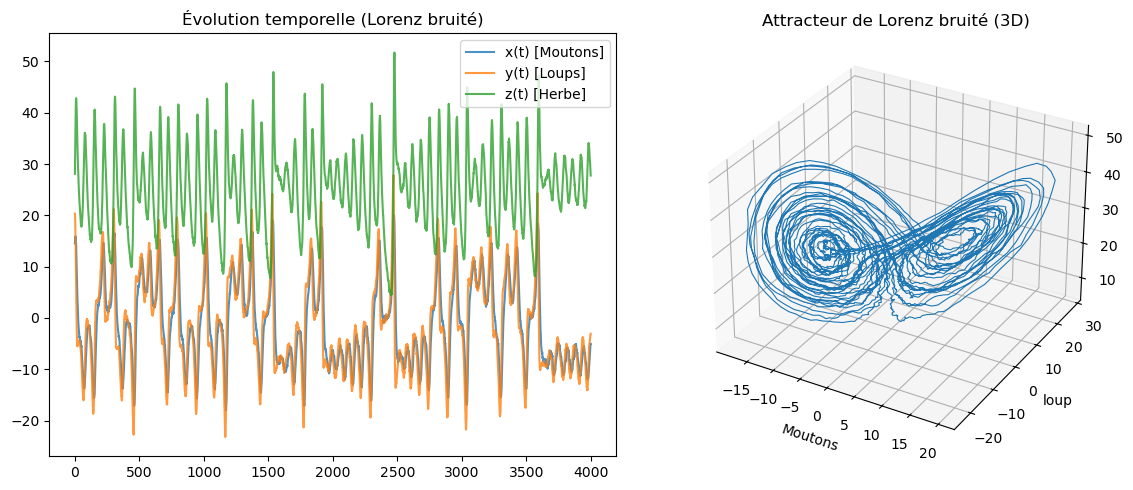

In [ ]:
x_mouton,y_loup,z_herbe = load_variables_lorenz()
plot_lorenz(x_mouton,y_loup,z_herbe)


[X-only attracteur] Corrélation CCM(X->Y) = 1.000


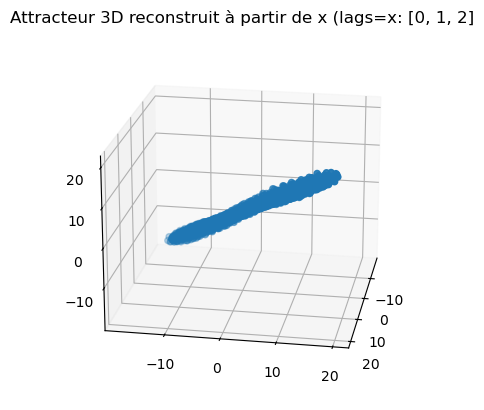

[X-only attracteur] Corrélation CCM(X->Y) = 1.000


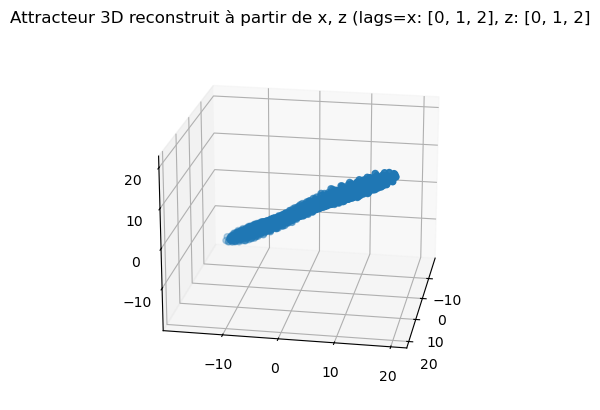

In [ ]:
data_dict = {'x': x_mouton, 'y': y_loup, 'z': z_herbe}
         
            
# lags :  3 composantes sur x => embedding dimension=3
# pas de lags pour y ni y => on ne les utilisent pas dans l'attracteur
lags = {'x': [0, 1, 2]}
y_est,embedding = get_embedding_and_reconstruct(data_dict,target_variable='y',lags =lags, k=4,use_weighted_mean=True)
plot_reconstruction(embedding,lags)
    

lags = {'x': [0, 1, 2],'z': [0,1,2]}
y_est,embedding = get_embedding_and_reconstruct(data_dict,target_variable='y',lags=lags,k=4,use_weighted_mean=True)
plot_reconstruction(embedding,lags)

'x: [0, 1, 2]'

In [ ]:
x_mouton,y_loup,z_herbe
# Test : CCM(Loups->Moutons)
E_dim = 3
tau_lag = 2
k_nn = 6
y_true, y_est = 





ccm_reconstruct(y_loup, x_mouton,
                                E=E_dim, tau=tau_lag, k=k_nn)
r_loups_moutons = correlation_coefficient(y_true, y_est)
print(f"Corrélation CCM(Loups->Moutons) = {r_loups_moutons:.3f}")

# Test : CCM(Moutons->Loups)
y_true2, y_est2 = ccm_reconstruct(x_mouton, y_loup,
                                  E=E_dim, tau=tau_lag, k=k_nn)

r_moutons_loups = correlation_coefficient(y_true2, y_est2)
print(f"Corrélation CCM(Moutons->Loups) = {r_moutons_loups:.3f}")

# Idem si vous voulez tester Herbe -> Moutons, etc.

plt.figure()
plt.plot(y_true[:200], label="Moutons (vrai)", alpha=0.7)
plt.plot(y_est[:200], label="Moutons (estimé via CCM Loups->Moutons)", alpha=0.7)
plt.title("Extrait reconstruction CCM(Loups->Moutons)")
plt.legend()
plt.show()

ccm_reconstruct_multivariate(embedding=emb_xz,
                                                    valid_time=valid_t_xz,
                                                    effect_series=y,
                                                    k=4,
                                                    use_weighted_mean=True)

    # ----------------------------------------------------
    # 4) Exemple d'analyse (CCM, etc.)
    # ----------------------------------------------------
    # Vous pouvez maintenant réutiliser votre code CCM, e.g.:
    #   ccm_reconstruct(x_noisy, y_noisy, E=3, tau=1, k=6)
    # pour voir la "causalité" X->Y.
    # Les résultats seront moins "parfaits" qu'en l'absence de bruit.

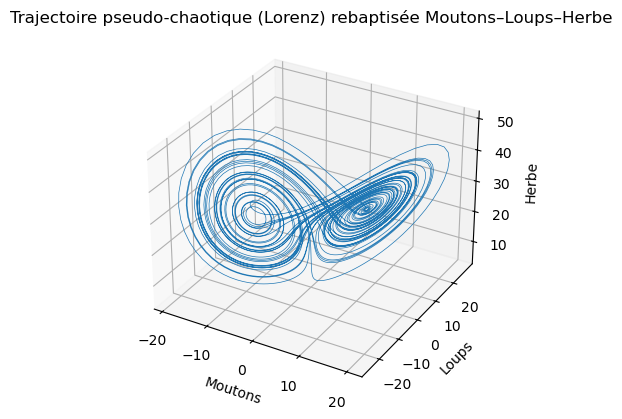

Corrélation CCM(Loups->Moutons) = 1.000
Corrélation CCM(Moutons->Loups) = 1.000


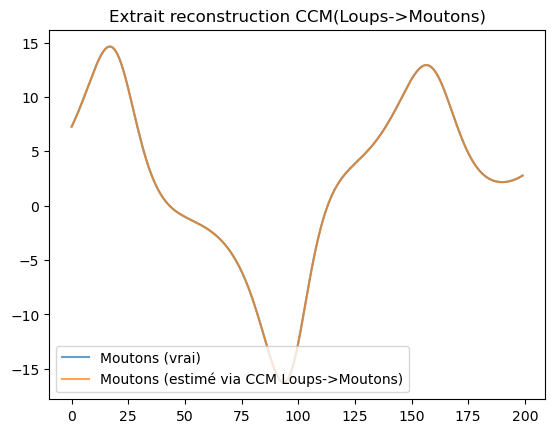

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from typing import Tuple

#####################
# 1) Système type Lorenz
#####################
def lorenz_system(state, sigma=10.0, rho=28.0, beta=8/3):
    """
    Équation de Lorenz :
    dx/dt = sigma*(y - x)
    dy/dt = x*(rho - z) - y
    dz/dt = x*y - beta*z
    """
    x, y, z = state
    dx = sigma * (y - x)
    dy = x * (rho - z) - y
    dz = x * y - beta * z
    return np.array([dx, dy, dz])

def simulate_lorenz(initial_state: np.ndarray,
                    dt: float = 0.01,
                    steps: int = 10000) -> np.ndarray:
    """
    Intégration d'Euler simple pour le système de Lorenz.
    Retourne un tableau (steps, 3) avec la trajectoire [x(t), y(t), z(t)].
    """
    traj = np.zeros((steps, 3))
    traj[0] = initial_state
    for i in range(1, steps):
        deriv = lorenz_system(traj[i-1])
        traj[i] = traj[i-1] + dt * deriv
    return traj

#####################
# 2) Génération des données "Moutons, Loups, Herbe"
#####################
np.random.seed(42)
initial_state = np.array([5.0, 5.0, 5.0])  # point de départ
data_lorenz = simulate_lorenz(initial_state, dt=0.01, steps=6000)
# Tronquons un peu le début pour éviter les transitoires
data_lorenz = data_lorenz[1000:]  # shape (5000, 3)

# On renomme : Moutons = X, Loups = Y, Herbe = Z
Moutons = data_lorenz[:, 0]
Loups = data_lorenz[:, 1]
Herbe = data_lorenz[:, 2]

#####################
# 3) Affichage 3D : "Papillon"
#####################
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.plot(Moutons, Loups, Herbe, lw=0.5)
ax.set_xlabel("Moutons")
ax.set_ylabel("Loups")
ax.set_zlabel("Herbe")
ax.set_title("Trajectoire pseudo-chaotique (Lorenz) rebaptisée Moutons–Loups–Herbe")
plt.show()

#####################
# 4) Petit test CCM
#####################

# (a) On échantillonne la fin de la trajectoire (par ex. 1000 points) pour avoir la série
M = 1000
Moutons_sample = Moutons[-M:]
Loups_sample = Loups[-M:]
Herbe_sample = Herbe[-M:]

# (b) On applique CCM => vous pouvez réutiliser votre fonction ccm_reconstruct_multivariate
#     ou ccm_reconstruct mono-série. Ex. : Loups -> Moutons
#     On donne juste un squelette illustratif (simplifié) :

from sklearn.neighbors import NearestNeighbors

def ccm_reconstruct(cause_series: np.ndarray,
                    effect_series: np.ndarray,
                    E: int = 3,
                    tau: int = 1,
                    k: int = 5) -> Tuple[np.ndarray, np.ndarray]:
    """
    CCM simple, monovarié. Reconstruit effect_series à partir de l'attracteur de cause_series.
    """
    N = len(cause_series)
    start_index = (E - 1) * tau
    # Attracteur
    M_points = []
    valid_t = []
    for t in range(start_index, N):
        coords = [cause_series[t - i*tau] for i in range(E)]
        M_points.append(coords)
        valid_t.append(t)
    M_points = np.array(M_points)
    valid_t = np.array(valid_t)

    # k-NN
    nbrs = NearestNeighbors(n_neighbors=k).fit(M_points)
    y_pred = []
    y_true = []
    for i, mp in enumerate(M_points):
        dist, idxs = nbrs.kneighbors(mp.reshape(1, -1))
        # Weighted average
        d = dist[0]
        d = np.where(d<1e-12, 1e-12, d)
        w = 1/d
        w /= w.sum()
        neighbors_t = valid_t[idxs[0]]
        val_neighbors = effect_series[neighbors_t]
        val_est = np.sum(val_neighbors * w)
        y_pred.append(val_est)
        # Valeur réelle
        t_i = valid_t[i]
        y_true.append(effect_series[t_i])
    return np.array(y_true), np.array(y_pred)

def corr(x, y):
    return np.corrcoef(x, y)[0, 1]


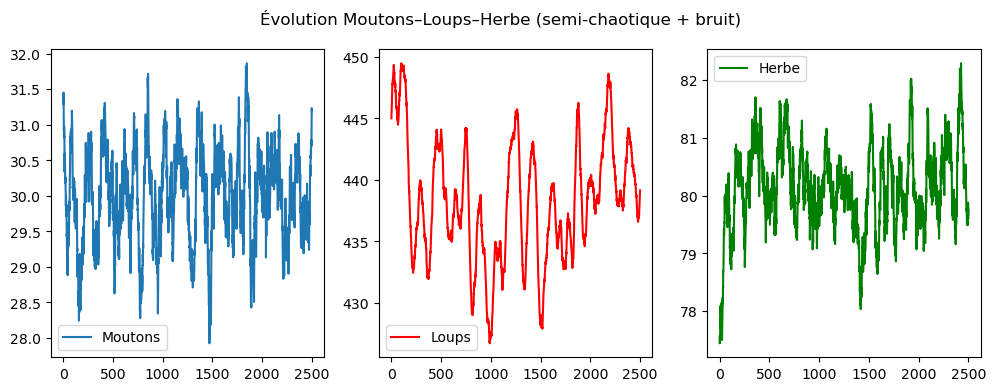

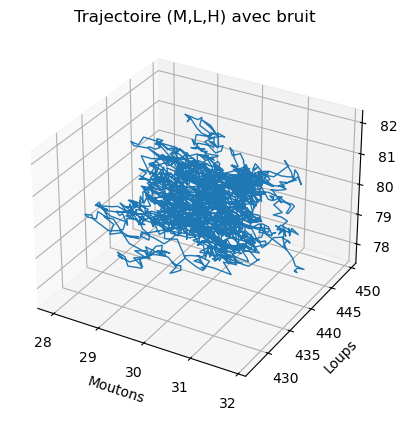

In [24]:
import numpy as np
import matplotlib.pyplot as plt

def ddt_moutons(m, l, h, params):
    """
    dM/dt pour les moutons, avec bruit
    """
    rM, KM, alphaML, alphaMH = params['rM'], params['KM'], params['alphaML'], params['alphaMH']
    growth_logistic = rM * m * (1 - m/KM)
    loss_predation = - alphaML * m * l
    gain_from_herbe = alphaMH * m * h
    return growth_logistic + loss_predation + gain_from_herbe

def ddt_loups(m, l, params):
    """
    dL/dt pour les loups, avec bruit
    """
    rL, alphaLM = params['rL'], params['alphaLM']
    # -rL*l => mortalité
    # + alphaLM * m * l => gain si proies (moutons)
    return -rL*l + alphaLM*m*l

def ddt_herbe(m, h, params):
    """
    dH/dt pour l'herbe
    """
    rH, KH, alphaHM = params['rH'], params['KH'], params['alphaHM']
    growth_logistic = rH * h * (1 - h/KH)
    loss_browse = - alphaHM * h * m
    return growth_logistic + loss_browse

def simulate_mlh(m0, l0, h0, dt, steps, params, noise_std=0.01):
    """
    Simulation d'Euler simple du système Moutons, Loups, Herbe avec bruit.
    :param m0, l0, h0: conditions initiales
    :param dt: pas de temps
    :param steps: nb d'itérations
    :param params: dict des paramètres
    :param noise_std: écart-type du bruit (Gaussien) ajouté à dM, dL, dH
    :return: arrays M, L, H shape (steps,)
    """
    M = np.zeros(steps)
    L = np.zeros(steps)
    H = np.zeros(steps)
    M[0] = m0
    L[0] = l0
    H[0] = h0

    for i in range(1, steps):
        m = M[i-1]
        l = L[i-1]
        h = H[i-1]

        dm = ddt_moutons(m, l, h, params) * dt
        dl = ddt_loups(m, l, params) * dt
        dh = ddt_herbe(m, h, params) * dt

        # Ajout de bruit
        dm += np.random.normal(0, noise_std)
        dl += np.random.normal(0, noise_std)
        dh += np.random.normal(0, noise_std)

        M[i] = max(0.0, m + dm)  # on évite les valeurs négatives
        L[i] = max(0.0, l + dl)
        H[i] = max(0.0, h + dh)

    return M, L, H

if __name__=="__main__":
    # Paramètres du système
    params = {
        'rM': 0.5,  # croissance moutons
        'KM': 50.0, # capacité logistique moutons
        'alphaML': 0.001, # impact loups sur moutons
        'alphaMH': 0.003, # gain si + herbe
        'rL': 0.15,  # mortalité loups
        'alphaLM': 0.005, # gain loups si + moutons
        'rH': 0.3,  # croissance herbe
        'KH': 100.0, # capacité herbe
        'alphaHM': 0.002 # broutage mouton sur herbe
    }

    # Conditions initiales
    m0 = 10.0
    l0 = 5.0
    h0 = 30.0

    # Simulation
    dt = 0.1
    steps = 3000
    noise_std = 0.15  # bruit un peu significatif
    M, L, H = simulate_mlh(m0, l0, h0, dt, steps, params, noise_std=noise_std)

    # On tronque un certain nombre de pas pour enlever le transitoire
    skip = 500
    M = M[skip:]
    L = L[skip:]
    H = H[skip:]

    # Affichage
    fig = plt.figure(figsize=(12,4))
    plt.subplot(1,3,1)
    plt.plot(M, label="Moutons")
    plt.legend()

    plt.subplot(1,3,2)
    plt.plot(L, 'r', label="Loups")
    plt.legend()

    plt.subplot(1,3,3)
    plt.plot(H, 'g', label="Herbe")
    plt.legend()
    plt.suptitle("Évolution Moutons–Loups–Herbe (semi-chaotique + bruit)")
    plt.show()

    # Affichage 3D
    from mpl_toolkits.mplot3d import Axes3D
    fig3d = plt.figure()
    ax3d = fig3d.add_subplot(projection='3d')
    ax3d.plot(M, L, H, lw=1.0)
    ax3d.set_xlabel("Moutons")
    ax3d.set_ylabel("Loups")
    ax3d.set_zlabel("Herbe")
    ax3d.set_title("Trajectoire (M,L,H) avec bruit")
    plt.show()

    # A ce stade, on peut :
    #  - Appliquer un CCM(M->L), CCM(L->M), CCM(H->M), etc.
    #  - Observer que le bruit rend la reconstruction moins parfaite.


In [ ]:
from jupyter_ipynb.Entropy_and_information.CCM import ccm_reconstruct,correlation_coefficient
import matplotlib.pyplot as plt
# ---------------------------
# 2) Graphique 3D (X,Y,Z) original
# ---------------------------
# Plot de l'espace "réel" (x(t), y(t), z(t)) 
fig1 = plt.figure()
ax1 = fig1.add_subplot(projection='3d')
ax1.scatter(x, y, z)
ax1.set_title("Espace original : (X(t), Y(t), Z(t))")
plt.show()

# ---------------------------
# 3) Reconstruction d'attracteur en 3D à partir de X(t)
# ---------------------------
# Prenons E=3, tau=2 pour l'illustration
E = 3
tau = 2
N = len(x)
start_index = (E - 1)*tau
embedding = []
for i in range(start_index, N):
    coords = [x[i - e*tau] for e in range(E)]
    embedding.append(coords)
embedding = np.array(embedding)  # shape (N - start_index, 3)

# Plot 3D de l'attracteur reconstruit
fig2 = plt.figure()
ax2 = fig2.add_subplot(projection='3d')
ax2.scatter(embedding[:, 0], embedding[:, 1], embedding[:, 2])
ax2.set_title("Attracteur reconstruit à partir de X(t), E=3, tau=2")
plt.show()

# ---------------------------
# 4) Convergent Cross Mapping: X -> Y
# ---------------------------
# Paramètres de CCM
ccm_dim = 3
ccm_tau = 1
ccm_k = 4

# On obtient y_true, y_est
y_true, y_est = ccm_reconstruct(
    cause_series=x,
    effect_series=y,
    E=ccm_dim,
    tau=ccm_tau,
    k=ccm_k
)

# Corrélation
rho = correlation_coefficient(y_true, y_est)
print(f"Corrélation CCM (X -> Y) = {rho:.3f}")

# Interprétation du signe
if rho > 0.1:  # Seuil arbitraire
    print("CCM suggère que X a une influence positive sur Y (corrélation > 0).")
else:
    print("Aucune influence notable détectée de X vers Y (corrélation faible ou nulle).")

# ---------------------------
# 5) Convergent Cross Mapping: Y -> X (test inverse)
# ---------------------------
x_true, x_est = ccm_reconstruct(
    cause_series=y,
    effect_series=x,
    E=ccm_dim,
    tau=ccm_tau,
    k=ccm_k
)

# Plot 3D de l'attracteur reconstruit
fig2 = plt.figure()
ax2 = fig2.add_subplot(projection='3d')
ax2.scatter(embedding[:, 0], embedding[:, 1], embedding[:, 2])
ax2.set_title("Attracteur reconstruit à partir de X(t), E=3, tau=2")
plt.show()

rho_yx = correlation_coefficient(x_true, x_est)
print(f"Corrélation CCM (Y -> X) = {rho_yx:.3f}")
if rho_yx > 0.1:
    print("CCM suggère que Y a une influence positive sur X.")
else:
    print("Aucune influence notable détectée de Y vers X.")